## Naive Preliminary Model for HAM10000

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image
import warnings 
import numpy as np
warnings.filterwarnings('ignore') 

import torchvision
from torchvision import transforms
import torch.utils.data as data

In [2]:
df = df2 = pd.read_csv('HAM 10000/HAM10000_metadata.csv')
df = df.dropna()
df = df[df['sex'] != 'unknown']
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Importing images into dataframe
for convenience, add 2 new columns to df (image path and image)

In [3]:
# get all image paths
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('HAM 10000/', '*', '*.jpg'))}
# Define the path and add as a new column
df['path'] = df['image_id'].map(image_path.get)
#Use the path to read images.
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

print(df['dx'].value_counts())

dx
nv       6650
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


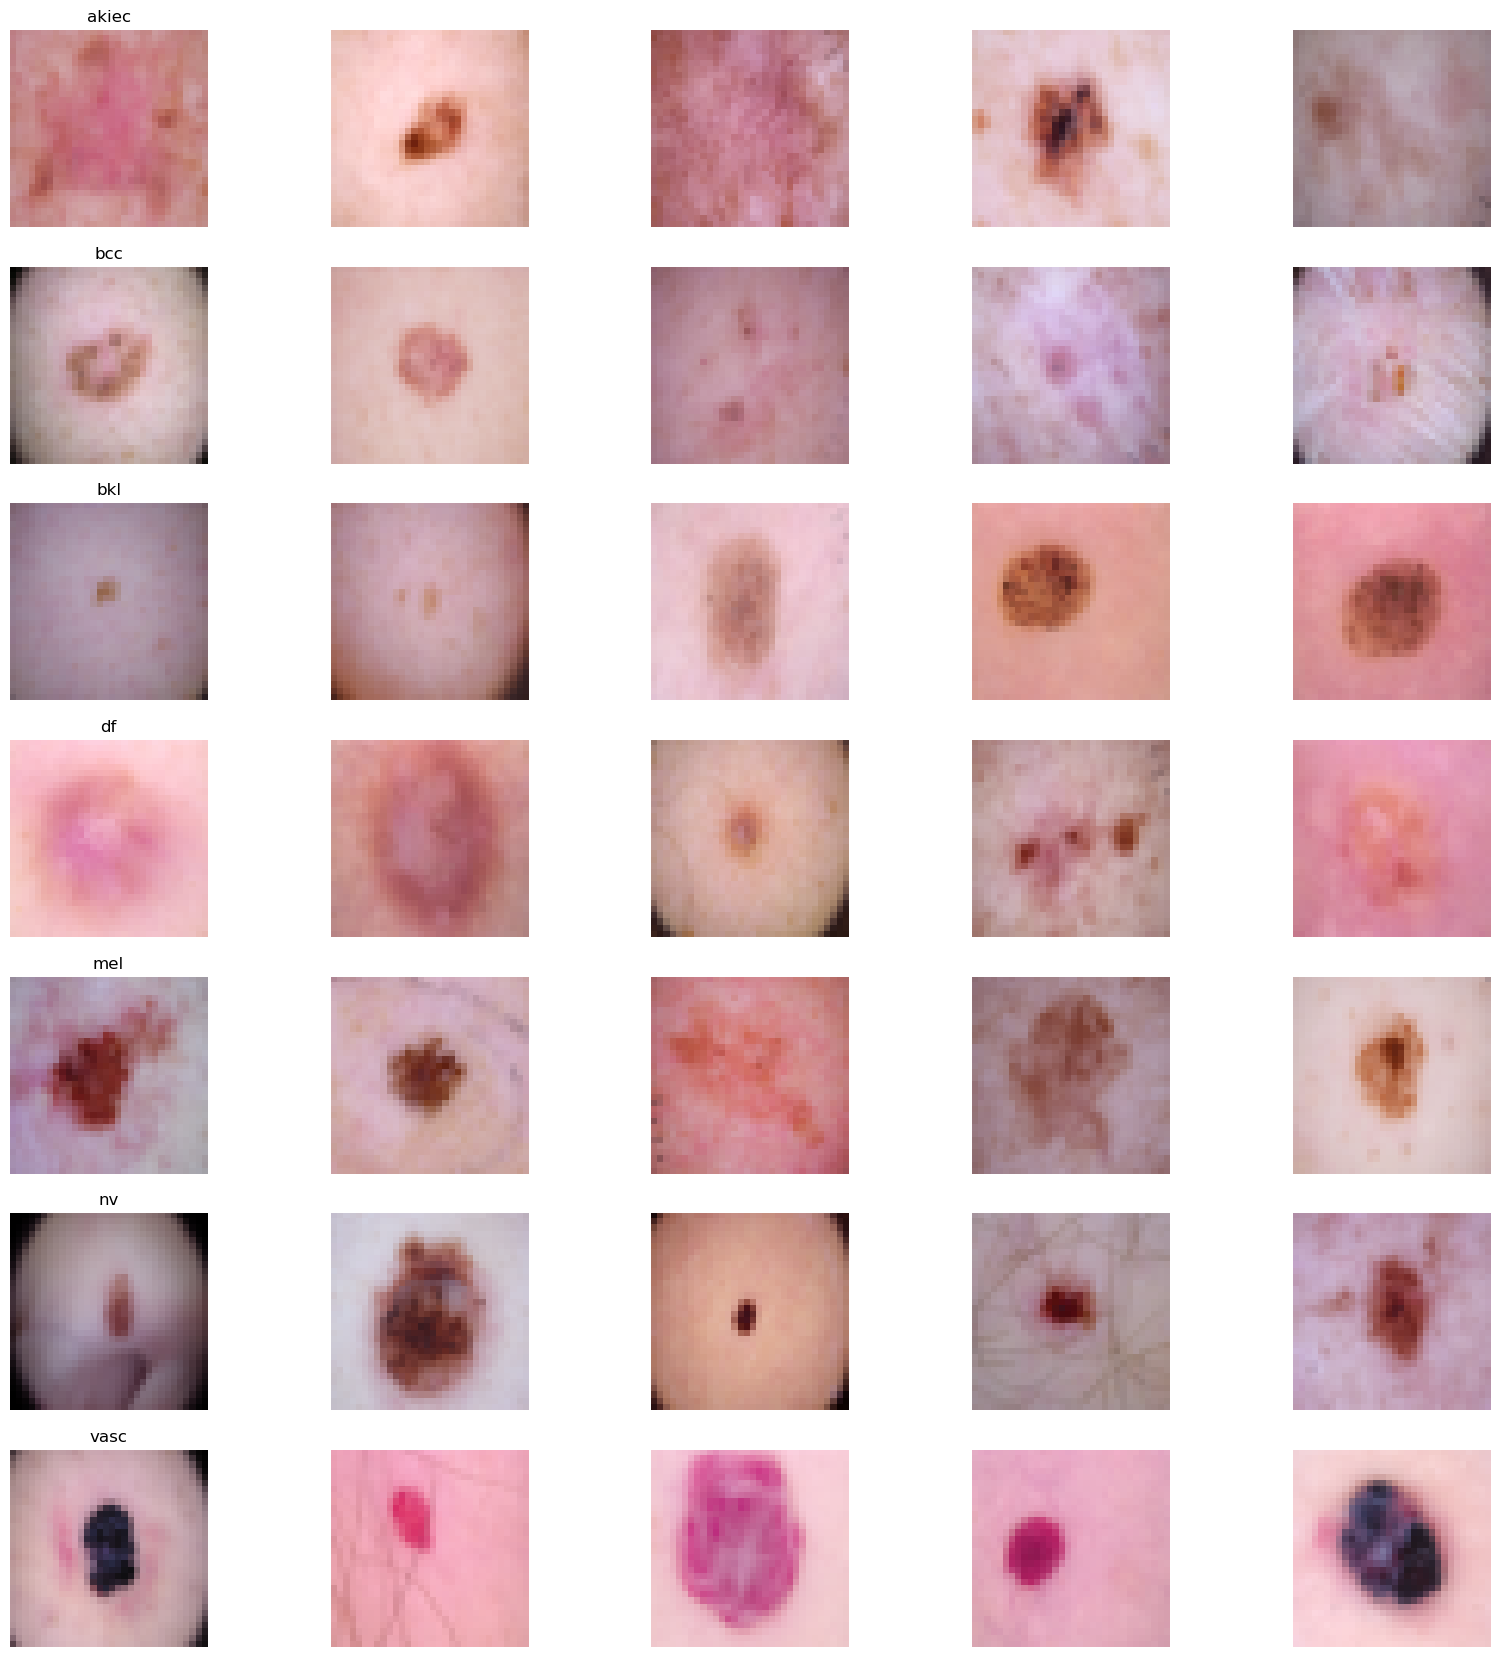

In [4]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM 10000/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


### Logistic Regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the data
X = np.array(df['image'].tolist())
y = df['dx']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the image arrays
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_flat, y_train)

# Evaluate the model
y_pred = model.predict(X_test_flat)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       akiec       0.18      0.15      0.16        60
         bcc       0.36      0.30      0.33        97
         bkl       0.37      0.27      0.31       224
          df       0.00      0.00      0.00        29
         mel       0.33      0.18      0.23       223
          nv       0.78      0.90      0.84      1336
        vasc       0.35      0.38      0.36        21

    accuracy                           0.68      1990
   macro avg       0.34      0.31      0.32      1990
weighted avg       0.63      0.68      0.65      1990

[[   9    7   16    1    4   22    1]
 [  13   29   12    2    4   33    4]
 [   6   15   61    2   22  118    0]
 [   5    5    3    0    1   15    0]
 [   7    9   29    2   40  135    1]
 [  11   11   45    3   49 1208    9]
 [   0    4    1    0    0    8    8]]


### Using CNN

#### Architecture used:
- 3 Convolutional layers each followed by ReLU activation function, max-pooling layer after each conv to reduce spatial dimensions
- 2 Fully connected layers; flatten output of last conv layer

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*4*4, 512)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Preprocessing and data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
])


class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['dx'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data.iloc[idx]['path'])
        label = self.data.iloc[idx]['encoded_label']
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label)


# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define datasets and dataloaders
train_dataset = SkinCancerDataset(train_df, transform=transform)
test_dataset = SkinCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model
num_classes = len(df['dx'].unique()) # Number of classes
model = CNN(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # print(type(images), type(labels))  # Print the type of images and labels
        images, labels = images.to(device), labels.to(device)  # Move each tensor to the device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct / total) * 100:.2f}%')


Epoch [1/10], Loss: 1.1098
Epoch [2/10], Loss: 0.9226
Epoch [3/10], Loss: 0.8712
Epoch [4/10], Loss: 0.8376
Epoch [5/10], Loss: 0.8146
Epoch [6/10], Loss: 0.7985
Epoch [7/10], Loss: 0.7699
Epoch [8/10], Loss: 0.7608
Epoch [9/10], Loss: 0.7425
Epoch [10/10], Loss: 0.7105
Accuracy on test set: 73.47%


In [8]:
# Continue with more epochs
# Training the model
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # print(type(images), type(labels))  # Print the type of images and labels
        images, labels = images.to(device), labels.to(device)  # Move each tensor to the device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct / total) * 100:.2f}%')

Epoch [1/30], Loss: 0.6891
Epoch [2/30], Loss: 0.6660
Epoch [3/30], Loss: 0.6448
Epoch [4/30], Loss: 0.6393
Epoch [5/30], Loss: 0.6256
Epoch [6/30], Loss: 0.6161
Epoch [7/30], Loss: 0.5942
Epoch [8/30], Loss: 0.5849
Epoch [9/30], Loss: 0.5575
Epoch [10/30], Loss: 0.5529
Epoch [11/30], Loss: 0.5556
Epoch [12/30], Loss: 0.5288
Epoch [13/30], Loss: 0.5060
Epoch [14/30], Loss: 0.4924
Epoch [15/30], Loss: 0.4764
Epoch [16/30], Loss: 0.4536
Epoch [17/30], Loss: 0.4461
Epoch [18/30], Loss: 0.4179
Epoch [19/30], Loss: 0.4061
Epoch [20/30], Loss: 0.3861
Epoch [21/30], Loss: 0.3636
Epoch [22/30], Loss: 0.3582
Epoch [23/30], Loss: 0.3467
Epoch [24/30], Loss: 0.3229
Epoch [25/30], Loss: 0.2965
Epoch [26/30], Loss: 0.2811
Epoch [27/30], Loss: 0.2659
Epoch [28/30], Loss: 0.2643
Epoch [29/30], Loss: 0.2207
Epoch [30/30], Loss: 0.2172
Accuracy on test set: 75.13%


Since accuracy doesn't really improve, need to take next steps to improve model